In [1]:
import json
import efel
import pandas
import numpy as np
import matplotlib
matplotlib.rcParams.update({'font.size': 8})
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
%matplotlib inline

In [69]:
def plot_traces(path, prefix, protocol, channels, recordings,
                vshift=0, title=None, figsize=(12, 8)):
    fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=figsize)
    ax1.set_ylabel('Voltage (mV)')
    ax2.set_ylabel('Current (pA)')
    ax2.set_xlabel('Time (ms)')
    if not title:
        title = protocol
    fig.suptitle(title)
    if len(recordings) > 1:
        color_cycle = [plt.cm.Blues(i) 
                       for i in np.linspace(0.3, 1, len(recordings))**2]
        ax1.set_prop_cycle('color', color_cycle)
        ax2.set_prop_cycle('color', color_cycle)
    for rec in reversed(recordings):
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        voltage = data[:, 1] - vshift
        ax1.plot(time, voltage)
        ax2.plot(time, current)
    return fig


def get_currents(path, prefix, protocol, channels, recordings, timing):
    currents = []
    for rec in recordings:
        print(rec)
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['current']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        current = data[:, 1]
        hold = current[np.where(time < timing['stimulus_start'])].mean()
        stim = current[np.where((timing['stimulus_start'] < time) 
                        & (time < timing['stimulus_end']))].mean()
        current = {}
        current['sweep'] = protocol + '_' + str(rec)
        current['holding_current_amp'] = hold
        current['holding_current_start'] = time[0]
        current['holding_current_end'] = time[-1]
        current['stimulus_total_amp'] = stim
        current['stimulus_amp'] = stim - hold
        current['stimulus_start'] = timing['stimulus_start']
        current['stimulus_end'] = timing['stimulus_end']
        currents.append(current)
    return currents


def extract(features, path, prefix, protocol, channels, recordings, timing,
            vshift=0, input_resistance=False):    
    stimuli = get_currents(path, prefix, protocol, channels, recordings, timing)
    traces = []
    for rec in recordings:
        # print(rec) #ok 
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        voltage = data[:, 1] - vshift
        trace = {}
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [timing['stimulus_start']]
        trace['stim_end'] = [timing['stimulus_end']]
        traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.set_setting('stimulus_current', 
                            stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.get_feature_values(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]
    print(res)
    return res


In [ ]:
def extract(features, path, prefix, protocol, channels, recordings, timing,
            vshift=0, input_resistance=False):    
    stimuli = get_currents(path, prefix, protocol, channels, recordings, timing)
    traces = []
    for rec in recordings:
        fullname = path + '/' + prefix + '_' + protocol \
            + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
        data = np.loadtxt(fullname)
        time = data[:, 0]
        voltage = data[:, 1] - vshift
        trace = {}
        trace['T'] = time
        trace['V'] = voltage
        trace['stim_start'] = [timing['stimulus_start']]
        trace['stim_end'] = [timing['stimulus_end']]
        traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.set_setting('stimulus_current', 
                              stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.get_feature_values(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]
    return res


In [3]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '180418_FS5'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 6, 'voltage': 7}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
repetitions = [range(1925, 1945)]


features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train



spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)


/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AHP_depth, An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AHP_depth_abs, An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AHP_depth_abs_slow, An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeW

[({'sweep': 'IDthresh_1925', 'holding_current_amp': 248.363125, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 324.65346534653463, 'stimulus_amp': 76.29034034653463, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': None, 'AHP_depth_abs': None, 'AHP_depth_abs_slow': None, 'AHP_slow_time': None, 'AHP_time_from_peak': None, 'AP_amplitude': None, 'AP_begin_voltage': None, 'AP_fall_rate': None, 'AP_rise_rate': None, 'ISI_CV': None, 'Spikecount': array([0]), 'adaptation_index2': None, 'inv_first_ISI': None, 'mean_frequency': None, 'min_voltage_between_spikes': None, 'peak_voltage': None, 'spike_half_width': None, 'steady_state_voltage': array([-89.42806516]), 'time_to_first_spike': None, 'voltage_base': array([-103.381248])}), ({'sweep': 'IDthresh_1926', 'holding_current_amp': 248.408125, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 327.1877187718772, 'stimulus_amp': 78.77959377187719, 'stimulus_start': 100,

In [4]:
repetitions = [range(1925, 1945)]
for recordings in repetitions:
    print(recordings)
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    print(res)
    print(len(spec['cell_features'][feature_protocol]))
    #.extend(res)
    #print(spec['cell_features']['IDthresh'])

range(1925, 1945)


/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AHP_depth, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(


[({'sweep': 'IDthresh_1925', 'holding_current_amp': 248.363125, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 324.65346534653463, 'stimulus_amp': 76.29034034653463, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': None, 'AHP_depth_abs': None, 'AHP_depth_abs_slow': None, 'AHP_slow_time': None, 'AHP_time_from_peak': None, 'AP_amplitude': None, 'AP_begin_voltage': None, 'AP_fall_rate': None, 'AP_rise_rate': None, 'ISI_CV': None, 'Spikecount': array([0]), 'adaptation_index2': None, 'inv_first_ISI': None, 'mean_frequency': None, 'min_voltage_between_spikes': None, 'peak_voltage': None, 'spike_half_width': None, 'steady_state_voltage': array([-89.42806516]), 'time_to_first_spike': None, 'voltage_base': array([-103.381248])}), ({'sweep': 'IDthresh_1926', 'holding_current_amp': 248.408125, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 327.1877187718772, 'stimulus_amp': 78.77959377187719, 'stimulus_start': 100,

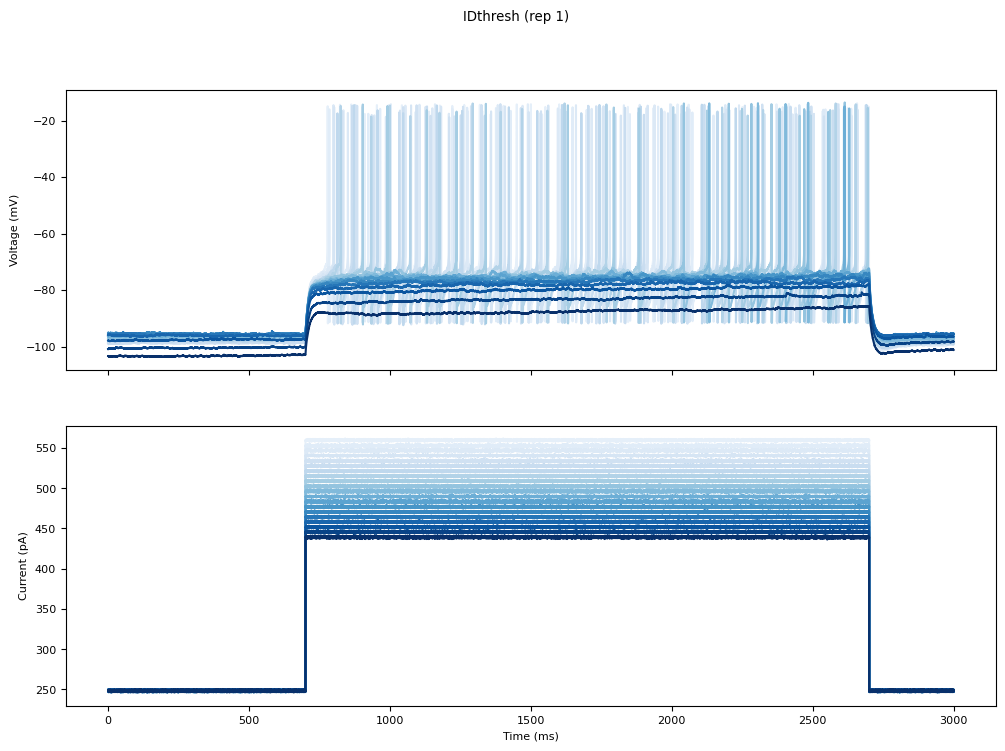

In [5]:
for recordings in repetitions[0:1]:
    fig = plot_traces(cell, prefix, protocol, channels, recordings, 
                      title=feature_protocol + ' (rep %d)' % len(repetitions),
                     vshift=liquid_junction_potential)
    plt.show()

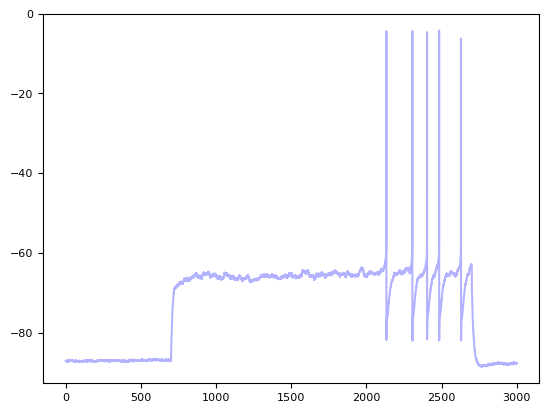

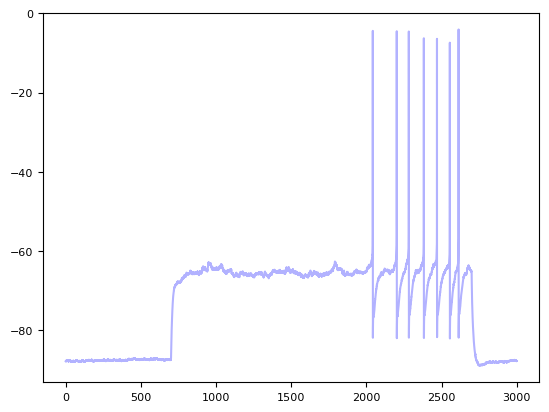

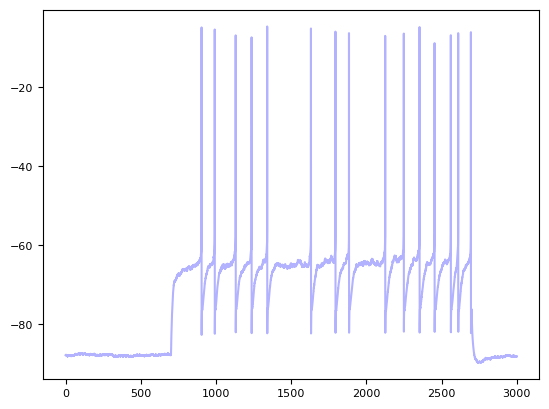

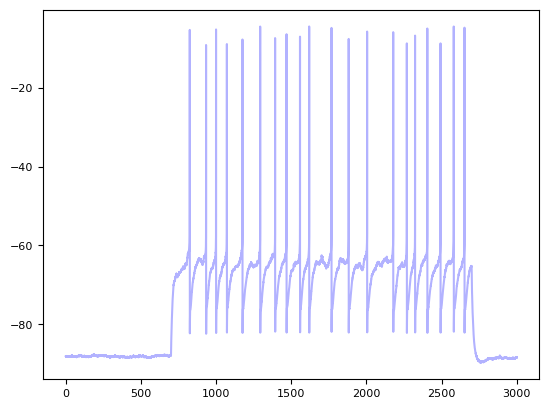

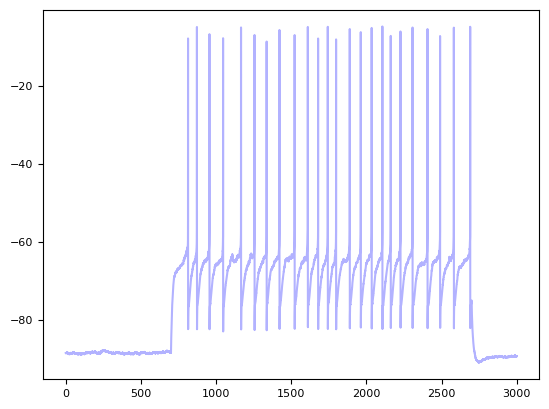

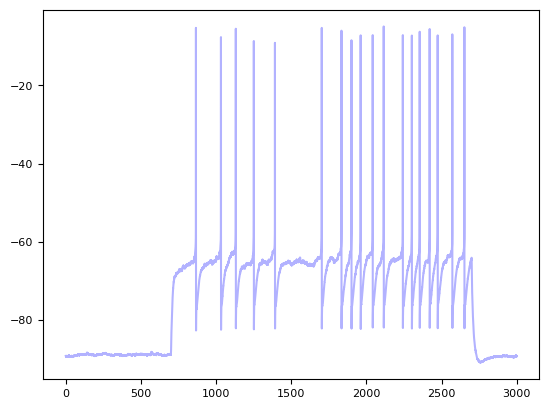

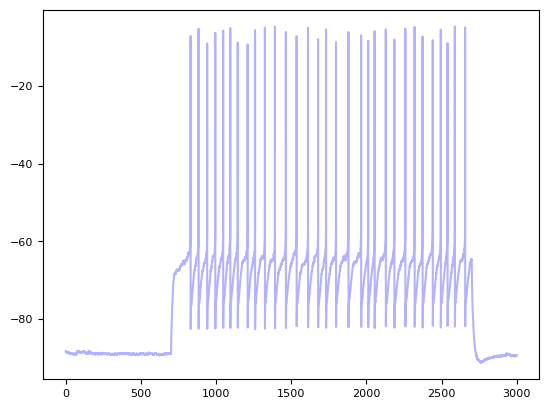

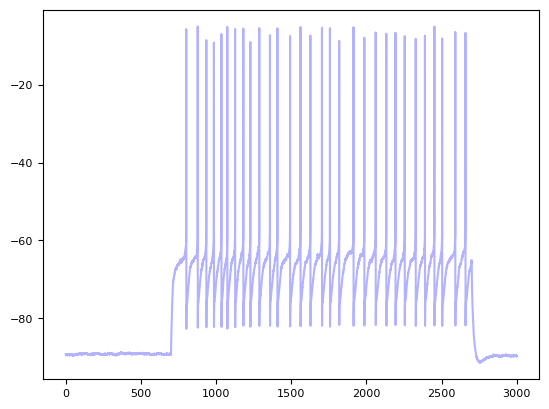

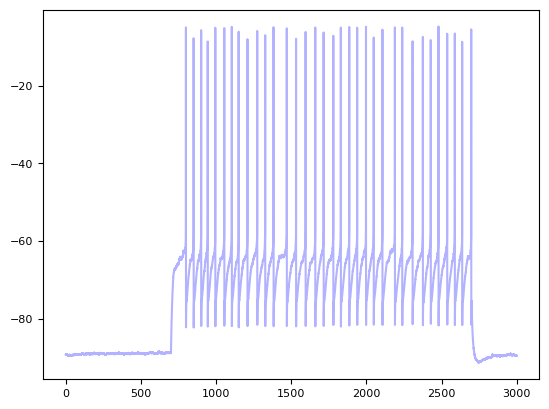

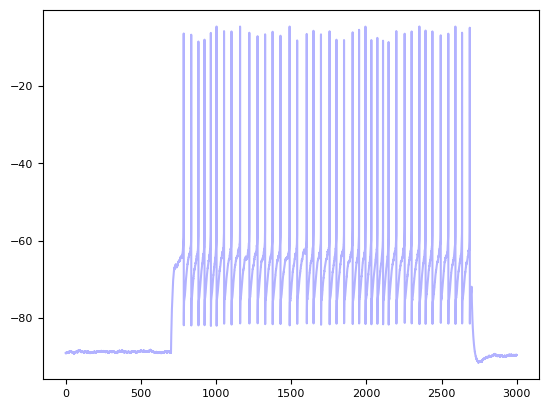

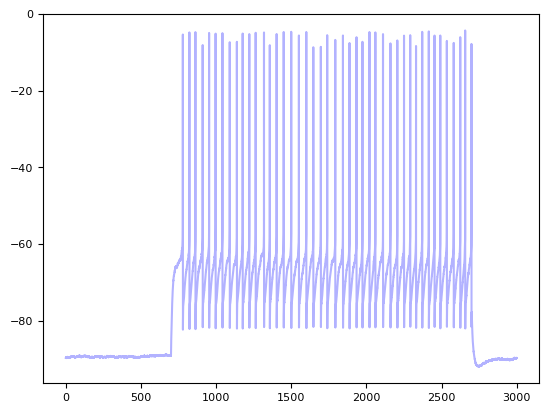

In [79]:
from scipy.signal import find_peaks

protocol_1 = 'IDthresh'
feature_protocol_1 = protocol_1
path_1 = cell
prefix_1 = 'ECall'
channels = {'current': 6, 'voltage': 7}
vshift=0
input_resistance=False

list_rec = []
for rec in  range(1925, 1945):
    fullname = path_1 + '/' + prefix_1 + '_' + protocol_1 \
    + '_ch' + str(channels['voltage']) + '_' + str(rec) + '.dat'
    data = np.loadtxt(fullname)
    time = data[:, 0]
    voltage = data[:, 1]
    peak_tuple = find_peaks(voltage, height= -30)
    if peak_tuple[0].size > 1:
        list_rec.append(rec)
        plt.plot(time,voltage, 'b', alpha=0.3)
        plt.show()
        

In [80]:

protocol_1 = 'IDthresh'
feature_protocol_1 = protocol_1
path_1 = cell
prefix_1 = 'ECall'
channels = {'current': 6, 'voltage': 7}
vshift=0
input_resistance=False


repetitions = [list_rec]  
print(list_rec)
features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train

spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, path_1, prefix_1, protocol_1, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)
print(spec['cell_features'][feature_protocol])

[1934, 1935, 1936, 1937, 1938, 1939, 1940, 1941, 1942, 1943, 1944]
1934
1935
1936
1937
1938
1939
1940
1941
1942
1943
1944
[({'sweep': 'IDthresh_1934', 'holding_current_amp': 248.36, 'holding_current_start': 0.0, 'holding_current_end': 2999.9, 'stimulus_total_amp': 347.4408065806581, 'stimulus_amp': 99.08080658065808, 'stimulus_start': 100, 'stimulus_end': 1100}, {'AHP_depth': array([5.376614, 5.182814, 5.614014, 5.270314, 5.282814]), 'AHP_depth_abs': array([-91.3812, -91.575 , -91.1438, -91.4875, -91.475 ]), 'AHP_depth_abs_slow': array([-85.5938, -85.1437, -85.5188]), 'AHP_slow_time': array([0.05204082, 0.06351183, 0.03502747]), 'AHP_time_from_peak': array([0.6, 0.6, 0.6, 0.6, 0.6]), 'AP_amplitude': None, 'AP_begin_voltage': array([-66.79380001, -65.76880001, -66.50630001, -67.37500001,
       -66.52500001]), 'AP_fall_rate': array([-129.16658309, -129.583333  , -153.7499997 , -129.66666639,
       -151.54999982]), 'AP_rise_rate': array([132.28137466, 173.14599939, 130.9844997 , 134.218

/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AP_amplitude, Feature [AP_amplitude] data is missing

  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating adaptation_index2, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
An error occurred while computing the feature, feature is not found. At least 4 spikes within stimulus interval needed for adaptation_index2.
  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating adaptation_index2, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set usi

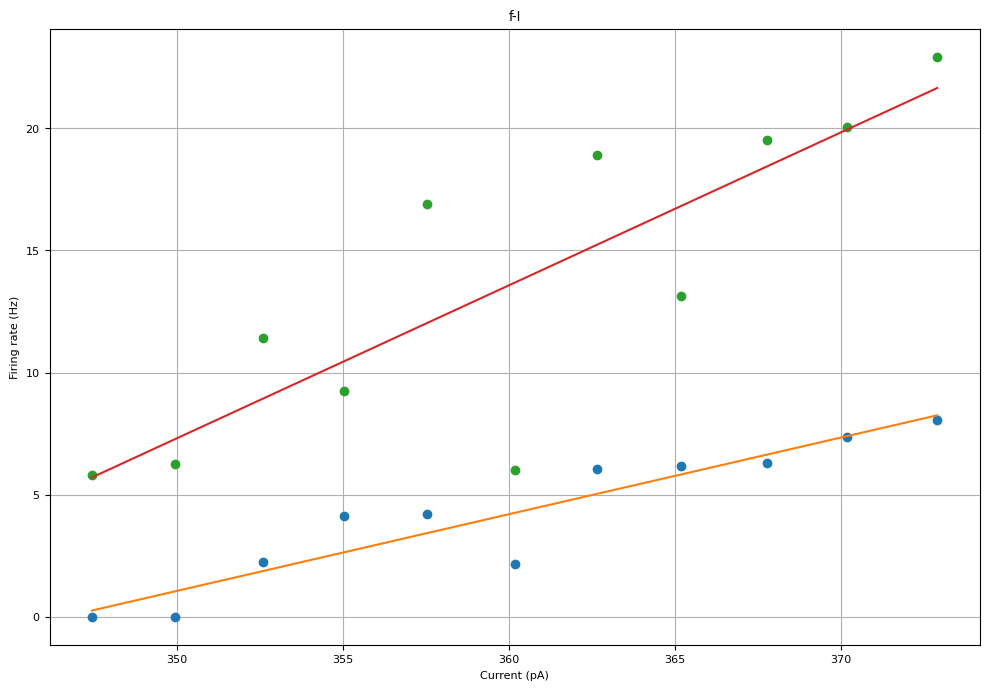

In [81]:
f_i = []
f_i1 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i1.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i.sort(key=lambda x: x[0])
f_i1.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i])
yy = np.array([x[1] for x in f_i])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i1])
y1 = np.array([x[1] for x in f_i1])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.show()

In [44]:
cell_type = 'FS'
cell_path = 'fs/derived/'
cell_id = '180418_FS5'
cell = cell_path + cell_id
prefix = 'ECall'
channels = {'current': 6, 'voltage': 7}
liquid_junction_potential = 9.5

spec = {}
spec['cell_id'] = cell_id
spec['cell_type'] = cell_type
spec['cell_features'] = {}
spec['temperature'] = 35
spec['liquid_junction_potential'] = liquid_junction_potential

protocol = 'IDthresh'
feature_protocol = protocol
repetitions = [range(1925, 1945)]


features_train = ['AHP_depth', 'AHP_depth_abs', 'AHP_depth_abs_slow',
                  'AHP_slow_time', 'AHP_time_from_peak', 'AP_amplitude',
                  'AP_begin_voltage', 'AP_fall_rate', 'AP_rise_rate', 
                  'ISI_CV', 'Spikecount', 'adaptation_index2', 
                  'inv_first_ISI', 'mean_frequency',
                  'min_voltage_between_spikes', 'peak_voltage',
                  'spike_half_width', 'steady_state_voltage', 
                  'time_to_first_spike', 'voltage_base']
features = features_train



spec['cell_features'][feature_protocol] = []
for recordings in repetitions:
    res = extract(features, cell, prefix, protocol, channels, recordings, 
              timing={'stimulus_start': 100, 'stimulus_end': 1100},
                 vshift=liquid_junction_potential)
    spec['cell_features'][feature_protocol].extend(res)

/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: RuntimeWarning: Error while calculating AHP_depth, Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
Parameter [offset] is missing in the map. In the python interface, this can be set using the appropriate setting function
An error occurred while computing the feature, feature is not found. Voltage never goes below or above threshold in spike detection.
  warnings.warn(
/home/abonard/anaconda3/lib/python3.12/site-packages/efel/pyfeatures/cppfeature_access.py:14: R

In [45]:
f_i = []
f_i1 = []
for stim, feat in spec['cell_features']['IDthresh']:
    f_i.append((stim['stimulus_total_amp'], feat['mean_frequency'][0]))
    f_i1.append((stim['stimulus_total_amp'], feat['inv_first_ISI'][0]))
f_i.sort(key=lambda x: x[0])
f_i1.sort(key=lambda x: x[0])

fig, ax = plt.subplots(figsize=(12,8))
ax.set_xlabel('Current (pA)')
ax.set_ylabel('Firing rate (Hz)')
ax.set_title('f-I')
ax.grid()
xx = np.array([x[0] for x in f_i])
yy = np.array([x[1] for x in f_i])
p = np.polyfit(xx, yy, 1)
ax.plot(xx, yy, 'o')
ax.plot(xx, p[1]+p[0]*xx, '-')
x1 = np.array([x[0] for x in f_i1])
y1 = np.array([x[1] for x in f_i1])
p1 = np.polyfit(x1, y1, 1)
ax.plot(x1, y1, 'o')
ax.plot(x1, p1[1]+p1[0]*x1, '-')
plt.show()

TypeError: 'NoneType' object is not subscriptable

In [ ]:

spec['cell_features'][feature_protocol] = []
timing={'stimulus_start': 100, 'stimulus_end': 1100}
traces = []
currents = []

for recordings in repetitions:
        
    current = data[:, 1]
    hold = current[np.where(time < timing['stimulus_start'])].mean()
    stim = current[np.where((timing['stimulus_start'] < time) 
                    & (time < timing['stimulus_end']))].mean()
    current = {}
    current['sweep'] = protocol + '_' + str(rec)
    current['holding_current_amp'] = hold
    current['holding_current_start'] = time[0]
    current['holding_current_end'] = time[-1]
    current['stimulus_total_amp'] = stim
    current['stimulus_amp'] = stim - hold
    current['stimulus_start'] = timing['stimulus_start']
    current['stimulus_end'] = timing['stimulus_end']
    currents.append(current)
    stimuli =  currents

    trace = {}
    trace['T'] = time
    trace['V'] = voltage
    trace['stim_start'] = [timing['stimulus_start']]
    trace['stim_end'] = [timing['stimulus_end']]
    traces.append(trace)
    if input_resistance:
        pA = 1e-12
        mV = 1e-3
        MOhm = 1e6
        efel.set_setting('stimulus_current', 
                            stimuli[0]['stimulus_amp']/(mV/pA/MOhm))
    feature_values = efel.get_feature_values(traces, features)
    res = [(s, f) for s, f in zip(stimuli, feature_values)]

    spec['cell_features'][feature_protocol].extend(res)


    #time = data[:, 0]
    #voltage = data[:, 1] - vshift
    #trace = {}
    #trace['T'] = time
    #trace['V'] = voltage
    #trace['stim_start'] = [timing['stimulus_start']]
    #trace['stim_end'] = [timing['stimulus_end']]
    #traces.append(trace)
    
    #feature_values = efel.get_feature_values(traces, features)
    #res = [(s, f) for s, f in zip(stimuli, feature_values)]
